# 0. Load CMIP6 Data with Intake ESM

[Intake ESM](https://intake-esm.readthedocs.io/en/latest/) is an experimental new package that aims to provide a higher-level interface to searching and loading Earth System Model data archives, such as CMIP6. 

Also check: [Accessing CMIP6 data with intake-esm](https://intake-esm.readthedocs.io/en/stable/tutorials/loading-cmip6-data.html#accessing-cmip6-data-with-intake-esm)

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import matplotlib.pyplot as plt
%matplotlib inline
import xesmf as xe
import os
import pandas as pd

# from xmip.preprocessing import combined_preprocessing
# from xmip.postprocessing import merge_variables
from xmip.postprocessing import match_metrics
# from xmip.utils import google_cmip_col
from copy import deepcopy

from tqdm.notebook import tqdm

Intake ESM works by parsing an [ESM Collection Spec](https://github.com/NCAR/esm-collection-spec/) and converting it to an [intake catalog](https://intake.readthedocs.io/en/latest). The collection spec is stored in a .json file. Here we open it using intake.

## Load the Google CMIP collection

In [2]:
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)
display(col)


# does the same thing as above
# col = google_cmip_col()
# col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


## Search for specific datasets

### List datasets used by Tello et al.

In [3]:
# selection of train and test datasets as in Tello et al. Figure 2
DEV1 = ['CAS-ESM2-0', 'EC-Earth3-AerChem', 'EC-Earth3-Veg', 'EC-Earth3', 'GISS-E2-1-H', 'MRI-ESM2-0']
DEV2 = ['BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-f3-L', 'GISS-E2-1-G', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR']
TEST = ['BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'EC-Earth3-Veg', 'EC-Earth3', 'FGOALS-f3-L', 'GISS-E2-1-G', 'GISS-E2-1-H', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0']

all_tello_sources = list(set(DEV1 + DEV2 + TEST))

### Query Pangeo CMIP6 Google cloud repository
The intake-esm search method returns a subset of the collection with all the entries that match the provided query. 

Here are the search parameters:

- variables:
    - `tos`: temperature of surface
    - `zos`: sea surface height (proxy for heat content)
    - zonal wind (U)
         - `uas`: Eastward Near-Surface Wind [m s-1]
         - `ua`: Eastward Wind [m s-1]
    - meridional wind (V)
         - `vas`: Northward Near-Surface Wind [m s-1]
         - `va`: Northward Wind [m s-1]
    - `areacello`: Grid-Cell Area for Ocean Variables
- experiments: 
    - `historical`: all forcing of the recent past
    - `piControl`: pre-industrial control simulation
    - `1pctCO2`:  1 % per year increasing CO2 simulation
- tables:
    - `Amon`: Monthly atmospheric data
    - `Omon`: Monthly Mean Ocean Fields
    - `Ofx`: Ocean fixed (does not change over time)
- members
    - `r1i1p1f1`: realizations / initial_condiditions / physics / forcing
- grids:
    - `gn`: native grid
    - `gr`: regridded data

In [4]:
experiments = ['historical'] # 'historical' = all forcing of the recent past; 'piControl' = pre-industrial control simulation
# variables = ['tos', 'zos', 'ua', 'va', 'uas', 'vas']
variables = ['tos']
tables = ['Omon', 'Amon']
members = ['r1i1p1f1']
grids = ['gn', 'gr'] # data reported on a model’s native grid.

# create a smaller catalog from the full collection using faceted search
print(f"Query collection for: \n• sources: {sorted(all_tello_sources)}, \n• experiments: {experiments}, \n• variables: {variables}, \n• tables: {tables}, \n• members: {members}, \n• grids: {grids}")
cat_tello = col.search(source_id=all_tello_sources,
                            experiment_id=experiments, 
                            variable_id=variables, 
                            table_id=tables, 
                            member_id=members, 
                            grid_label=grids)


print(f"\n{cat_tello.df['source_id'].nunique()} sources out of {len(all_tello_sources)} were found")
for name in all_tello_sources:
    df = cat_tello.df[cat_tello.df['source_id'].str.fullmatch(name)]
    # display(df)
    if len(df) == 0: 
        print(f"{name:17}", end=f"{experiments}: ")
        print("not found")
        continue

# for column in cat_tello.df.columns:
#     print(cat_tello.df[column].value_counts())
#     print()

print()
print(cat_tello.df['variable_id'].value_counts())
# print(cat_tello.df['zstore'].value_counts())

display(cat_tello)
cat_tello.keys()

Query collection for: 
• sources: ['BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GISS-E2-1-G', 'GISS-E2-1-H', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0'], 
• experiments: ['historical'], 
• variables: ['tos'], 
• tables: ['Omon', 'Amon'], 
• members: ['r1i1p1f1'], 
• grids: ['gn', 'gr']

10 sources out of 13 were found
CAS-ESM2-0       ['historical']: not found
MIROC-ES2L       ['historical']: not found
EC-Earth3-Veg    ['historical']: not found

variable_id
tos    11
Name: count, dtype: int64


,unique
activity_id,1
institution_id,8
source_id,10
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,2
zstore,11
dcpp_init_year,0


['CMIP.BCC.BCC-ESM1.historical.Omon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Omon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Omon.gn',
 'CMIP.MIROC.MIROC6.historical.Omon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Omon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gr',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn']

#### All Tello datasets

In [5]:
cat_tello.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
1,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
2,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
3,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/hi...,NaN,20190403
4,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,NaN,20190708
5,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
6,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190904
7,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190904
8,CMIP,CAS,FGOALS-f3-L,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historic...,NaN,20191007
9,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200624


#### DEV1 datasets

In [6]:
# for name in DEV1:
#     print(name)
#     display(cat_tello[cat_tello['source_id'].str.fullmatch(name)])

cat_tello.df[cat_tello.df['source_id'].isin(DEV1)]

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
3,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/hi...,NaN,20190403
6,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190904
7,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190904
9,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200624
10,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200918


#### DEV2 datasets

In [7]:
# for name in DEV2:
#     print(name)
#     display(cat_tello[cat_tello['source_id'].str.fullmatch(name)])

cat_tello.df[cat_tello.df['source_id'].isin(DEV2)]

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
1,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
2,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
4,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,NaN,20190708
5,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
8,CMIP,CAS,FGOALS-f3-L,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historic...,NaN,20191007


#### TEST datasets

In [8]:
cat_tello.df[cat_tello.df['source_id'].isin(TEST)]

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
1,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
2,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
3,CMIP,NASA-GISS,GISS-E2-1-H,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/hi...,NaN,20190403
4,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,NaN,20190708
5,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
6,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190904
7,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190904
8,CMIP,CAS,FGOALS-f3-L,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historic...,NaN,20191007
10,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200918


Intake knows how to automatically open the datasets using xarray. Furthermore, intake esm contains special logic to concatenate and merge the individual results of our query into larger, more high-level aggregated xarray datasets.

## Load datasets using to_dataset_dict()
`Intake-esm` implements convenience utilities for loading the query results into higher level xarray datasets.

To load data assets into xarray datasets, we need to use the `to_dataset_dict()` method. This method returns a dictionary of aggregate xarray datasets as the name hints.

In [9]:
# dictionary of aggregate xarray datasets
# read all datasets into a dictionary (optionally apply the xmip preprocessing before)
kwargs = {
    'zarr_kwargs':{
        'consolidated':True,
        'use_cftime':True,
        'decode_times': True, 
    },
    # 'aggregate':False,
    # 'preprocess':combined_preprocessing
    # 'xarray_open_kwargs' : {'consolidated': True,'use_cftime':True, 'chunks':{}, 'decode_times': True, },
}


dset_dict = cat_tello.to_dataset_dict(**kwargs)

# dset_dict = cat_tello.to_dataset_dict(
#     xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
#     kwargs=kwargs
# )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
# Get keys for the catalog entries
list(dset_dict.keys())[:3]

['CMIP.BCC.BCC-ESM1.historical.Omon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gr',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gn']

In [11]:
dset_dict['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn']

<xarray.Dataset> Size: 1GB
Dimensions:             (y: 363, x: 360, time: 1980, bnds: 2, member_id: 1,
                         dcpp_init_year: 1, vertices: 4)
Coordinates:
    latitude            (y, x) float64 1MB dask.array<chunksize=(363, 360), meta=np.ndarray>
    longitude           (y, x) float64 1MB dask.array<chunksize=(363, 360), meta=np.ndarray>
  * time                (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16...
    time_bnds           (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x                   (x) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    x_bnds              (x, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * y                   (y) float64 3kB -78.0 -77.5 -77.0 ... 149.7 151.8 154.0
    y_bnds              (y, bnds) float64 6kB dask.array<chunksize=(363, 2), meta=np.ndarray>
  * member_id           (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (member_id, dcpp_init_year, time, y, x) float32 1GB dask.array<chunksize=(1, 1, 120, 363, 360), meta=np.ndarray>
    vertices_latitude   (y, x, vertices) float64 4MB dask.array<chunksize=(363, 360, 4), meta=np.ndarray>
    vertices_longitude  (y, x, vertices) float64 4MB dask.array<chunksize=(363, 360, 4), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gn

### Merge the variables into a single dataset
(currently in a dataset each) 

In [12]:
# sorted(list(dset_dict.keys()))

In [13]:
# dset_dict_merged = merge_variables(dset_dict)
# sorted(list(dset_dict_merged.keys()))

In [14]:
# # double check results as instructed by warning
# dset_dict_merged['FGOALS-f3-L.gn.historical.Omon.r1i1p1f1']

In [15]:
# for key in sorted(dset_dict_merged.keys()):
#     ds = dset_dict_merged[key]    
#     split_key = key.split(".")
#     print(f"{'.'.join(split_key[:2]):20} - Dims: {dict(ds.sizes)}")

In [16]:
# sorted(list(dset_dict_merged.keys()))

## Regrid the model resolution to 180 x 360
xESMF is a great package for regridding

### Define reference grid

<xarray.Dataset> Size: 513MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                     lon: 360, bnds: 2)
Coordinates:
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bnds        (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    lon_bnds        (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB dask.array<chunksize=(1, 1, 120, 180, 360), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gr

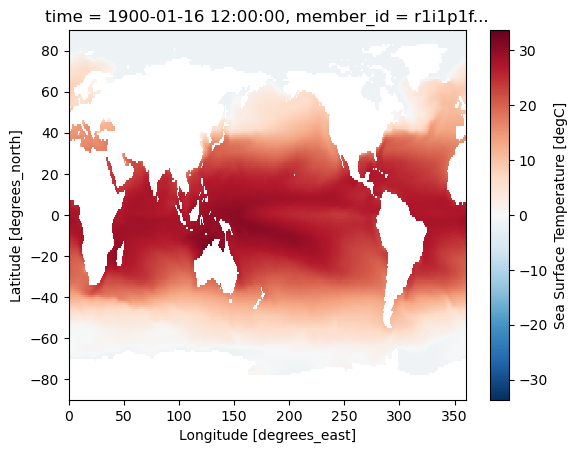

In [17]:
# reference grid
ds_ref_grid = dset_dict["CMIP.MRI.MRI-ESM2-0.historical.Omon.gr"] # use when variables not merging variables
# ds_ref_grid = dset_dict_merged["MRI-ESM2-0.gr.historical.Omon.r1i1p1f1"] # use when variables merged


# Convert the Dataset to another calendar
ds_ref_grid = ds_ref_grid.convert_calendar('standard', dim='time', use_cftime=True)
display(ds_ref_grid)

ds_ref_grid['tos'].sel(time="1900-01-16 12:00:00").plot()

In [18]:
# Read in the output grid from MRI-ESM2-0
ds_out = ds_ref_grid.copy(deep=True)

In [19]:
# regridding tutorial: https://nordicesmhub.github.io/forces-2021/learning/example-notebooks/xesmf_regridding.html

# create dictionary for reggridded data
ds_regrid_dict = dict()

for key in tqdm(dset_dict.keys()):
# for key in tqdm(dset_dict_merged.keys()):

    print(key)

    # ignore dataset creating a "Degenerate Element Detected" error
    if key == "CMIP.EC-Earth-Consortium.EC-Earth3.historical.Omon.gn" \
        or key == "CMIP.MPI-M.MPI-ESM1-2-HR.historical.Omon.gn" \
        or key == "CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Omon.gn":
        print("Degenerate Element Detected. Ignore dataset\n")
        continue

    # ignore merged datasets creating a "Degenerate Element Detected" error
    # if key == "EC-Earth3-AerChem.gn.historical.Omon.r1i1p1f1" \
    #     or key == "EC-Earth3.gn.historical.Omon.r1i1p1f1" \
    #     or key == "MPI-ESM1-2-HR.gn.historical.Omon.r1i1p1f1":
    #     continue
    
    # create new file name
    new_filename = key.replace(".gr", ".gr_regridded.nc").replace(".gn", ".gn_regridded.nc")
    # new_filename = key + ".nc"
    savepath = 'datasets/CMIP6/CMIP6_regridded/regridded'
    os.makedirs(savepath, exist_ok=True) 
    nc_out = os.path.join(savepath, new_filename)

    # if regridded file already exist on disk, load it
    if os.path.isfile(nc_out):
        print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
        ds_regrid_dict[new_filename] = xr.open_dataset(nc_out)
        continue
    
    ds_in = dset_dict[key]
    # ds_in = dset_dict_merged[key]

    
    # Convert the Dataset to another calendar (DatetimeGregorian)
    ds_in = dset_dict[key].convert_calendar('standard', dim='time', use_cftime=True)
    # ds_in = dset_dict_merged[key].convert_calendar('standard', dim='time', use_cftime=True)
    
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
    print(regridder)
    
    # Apply regridder to data
    ds_in_regrid = regridder(ds_in, keep_attrs=True)

    print(f"nc_out: {nc_out}")
    ds_in_regrid.to_netcdf(nc_out)
    
    # create dataset with all models
    ds_regrid_dict[new_filename] = ds_in_regrid
    
    print('file written: {}\n'.format(nc_out))

  0%|          | 0/11 [00:00<?, ?it/s]

CMIP.BCC.BCC-ESM1.historical.Omon.gn
CMIP.BCC.BCC-ESM1.historical.Omon.gn_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/regridded. Loading it from disk...

CMIP.MRI.MRI-ESM2-0.historical.Omon.gr
CMIP.MRI.MRI-ESM2-0.historical.Omon.gr_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/regridded. Loading it from disk...

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn
CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/regridded. Loading it from disk...

CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/regridded. Loading it from disk...

CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Omon.gn
Degenerate Element Detected. Ignore dataset

CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/regridded. Loading it from disk...

CMIP

In [20]:
list(ds_regrid_dict.keys())

['CMIP.BCC.BCC-ESM1.historical.Omon.gn_regridded.nc',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gr_regridded.nc',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_regridded.nc',
 'CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn_regridded.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_regridded.nc',
 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn_regridded.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_regridded.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_regridded.nc']

In [21]:
# !ls -ls --block-size=MB datasets/CMIP6/CMIP6_regridded/

In [22]:
# ds_regrid_dict['MRI-ESM2-0.gn.historical.Omon.r1i1p1f1.nc']

### Compare original to regridded and plot

BCC-ESM1
CMIP.BCC.BCC-ESM1.historical.Omon.gn


<xarray.Dataset> Size: 662MB
Dimensions:         (lat: 232, bnds: 2, lon: 360, time: 1980, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * lat             (lat) float64 2kB -81.5 -80.5 -79.5 -78.5 ... 87.5 88.5 89.5
    lat_bnds        (lat, bnds) float64 4kB dask.array<chunksize=(232, 2), meta=np.ndarray>
    latitude        (lat, lon) float32 334kB dask.array<chunksize=(232, 360), meta=np.ndarray>
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    lon_bnds        (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude       (lat, lon) float32 334kB dask.array<chunksize=(232, 360), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 661MB dask.array<chunksize=(1, 1, 120, 232, 360), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            2110.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/hist...
    intake_esm_attrs:version:         20181129
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.BCC.BCC-ESM1.historical.Omon.gn

CMIP.BCC.BCC-ESM1.historical.Omon.gn_regridded.nc


<xarray.Dataset> Size: 513MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                     lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
    time_bnds       (time, bnds) object 32kB ...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
Attributes: (12/66)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            2110.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/hist...
    intake_esm_attrs:version:         20181129
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.BCC.BCC-ESM1.historical.Omon.gn
    regrid_method:                    bilinear

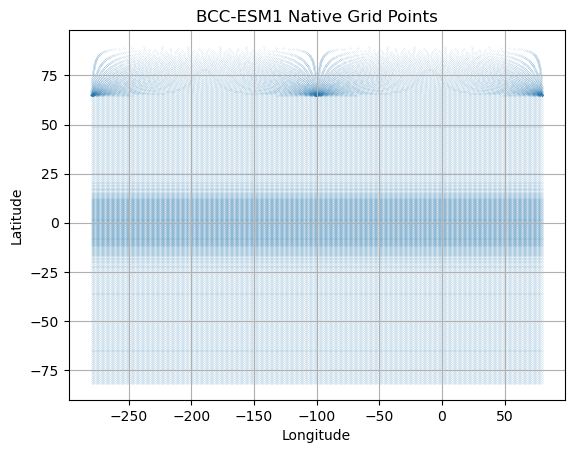

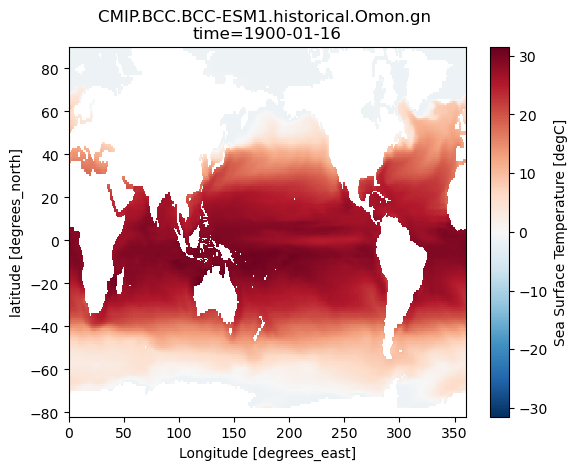

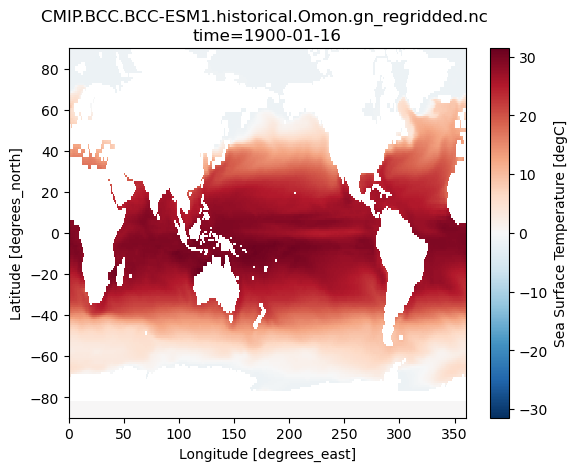





MRI-ESM2-0
CMIP.MRI.MRI-ESM2-0.historical.Omon.gr


<xarray.Dataset> Size: 513MB
Dimensions:         (lat: 180, bnds: 2, lon: 360, time: 1980, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bnds        (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    lon_bnds        (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB dask.array<chunksize=(1, 1, 120, 180, 360), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gr

CMIP.MRI.MRI-ESM2-0.historical.Omon.gr_regridded.nc


<xarray.Dataset> Size: 513MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                     lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
    time_bnds       (time, bnds) datetime64[ns] 32kB ...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gr
    regrid_method:                    bilinear

No latitude / longitude coordinates


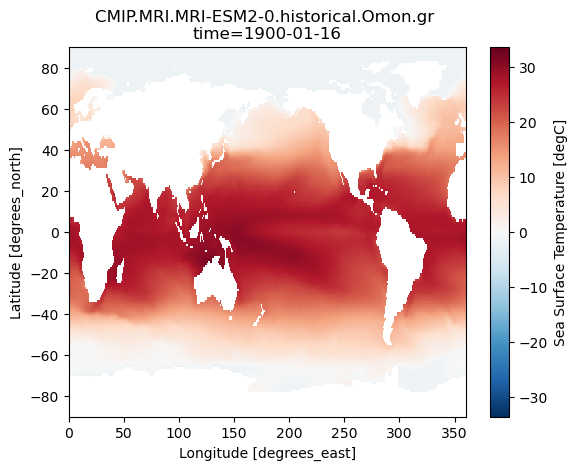

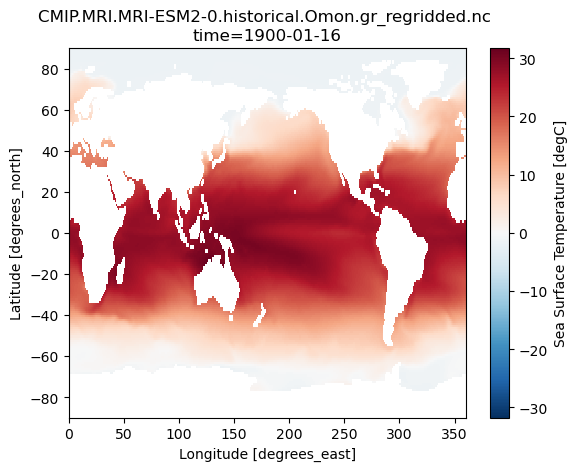





MRI-ESM2-0
CMIP.MRI.MRI-ESM2-0.historical.Omon.gn


<xarray.Dataset> Size: 1GB
Dimensions:             (y: 363, x: 360, time: 1980, bnds: 2, member_id: 1,
                         dcpp_init_year: 1, vertices: 4)
Coordinates:
    latitude            (y, x) float64 1MB dask.array<chunksize=(363, 360), meta=np.ndarray>
    longitude           (y, x) float64 1MB dask.array<chunksize=(363, 360), meta=np.ndarray>
  * time                (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16...
    time_bnds           (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x                   (x) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    x_bnds              (x, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * y                   (y) float64 3kB -78.0 -77.5 -77.0 ... 149.7 151.8 154.0
    y_bnds              (y, bnds) float64 6kB dask.array<chunksize=(363, 2), meta=np.ndarray>
  * member_id           (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (member_id, dcpp_init_year, time, y, x) float32 1GB dask.array<chunksize=(1, 1, 120, 363, 360), meta=np.ndarray>
    vertices_latitude   (y, x, vertices) float64 4MB dask.array<chunksize=(363, 360, 4), meta=np.ndarray>
    vertices_longitude  (y, x, vertices) float64 4MB dask.array<chunksize=(363, 360, 4), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gn

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_regridded.nc


<xarray.Dataset> Size: 9GB
Dimensions:             (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                         lon: 360, vertices: 4, bnds: 2)
Coordinates:
  * time                (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 20...
    time_bnds           (time, bnds) datetime64[ns] 32kB ...
  * member_id           (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
  * lat                 (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                 (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: vertices, bnds
Data variables:
    tos                 (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
    vertices_latitude   (vertices, time, lat, lon) float64 4GB ...
    vertices_longitude  (vertices, time, lat, lon) float64 4GB ...
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gn
    regrid_method:                    bilinear

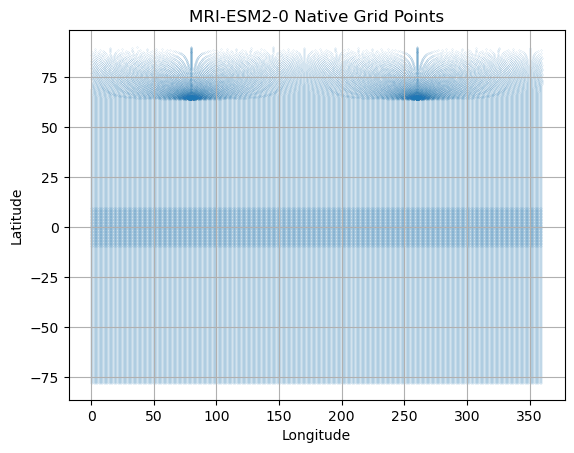

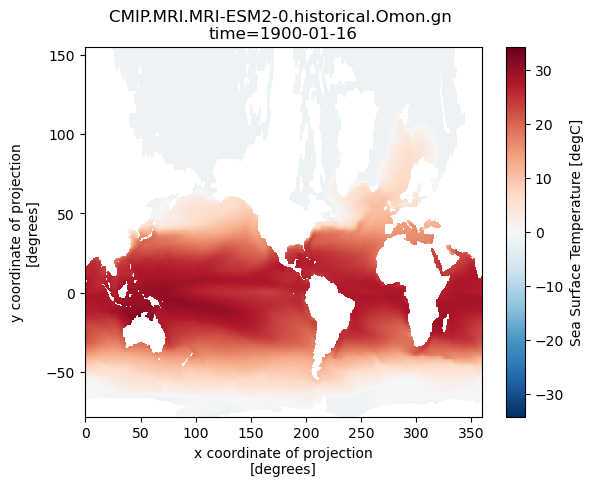

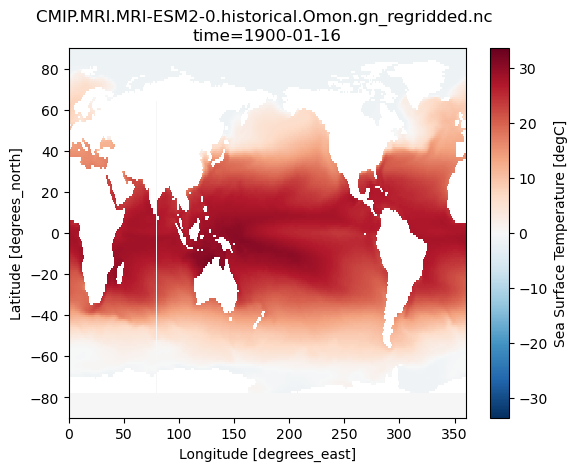





CAMS-CSM1-0
CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn


<xarray.Dataset> Size: 573MB
Dimensions:             (i: 360, j: 200, time: 1980, bnds: 2, member_id: 1,
                         dcpp_init_year: 1, vertices: 4)
Coordinates:
  * i                   (i) int32 1kB 1 2 3 4 5 6 7 ... 355 356 357 358 359 360
  * j                   (j) int32 800B 1 2 3 4 5 6 7 ... 195 196 197 198 199 200
    latitude            (j, i) float32 288kB dask.array<chunksize=(200, 360), meta=np.ndarray>
    longitude           (j, i) float32 288kB dask.array<chunksize=(200, 360), meta=np.ndarray>
  * time                (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16...
    time_bnds           (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id           (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (member_id, dcpp_init_year, time, j, i) float32 570MB dask.array<chunksize=(1, 1, 120, 200, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 1MB dask.array<chunksize=(200, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 1MB dask.array<chunksize=(200, 360, 4), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            3025.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/...
    intake_esm_attrs:version:         20190708
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn

CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn_regridded.nc


<xarray.Dataset> Size: 5GB
Dimensions:             (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                         lon: 360, vertices: 4, bnds: 2)
Coordinates:
  * time                (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 20...
    time_bnds           (time, bnds) object 32kB ...
  * member_id           (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
  * lat                 (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                 (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: vertices, bnds
Data variables:
    tos                 (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
    vertices_latitude   (vertices, time, lat, lon) float32 2GB ...
    vertices_longitude  (vertices, time, lat, lon) float32 2GB ...
Attributes: (12/66)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            3025.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/...
    intake_esm_attrs:version:         20190708
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn
    regrid_method:                    bilinear

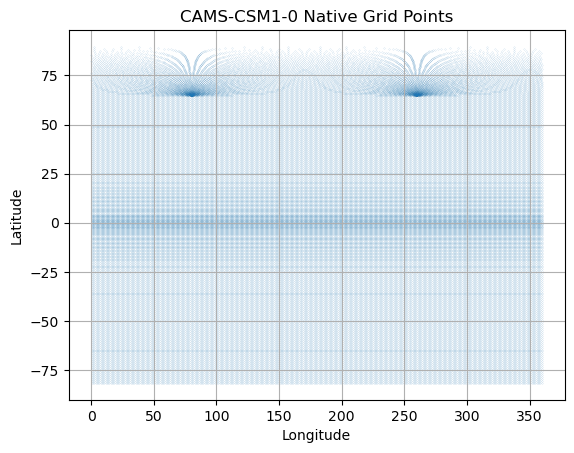

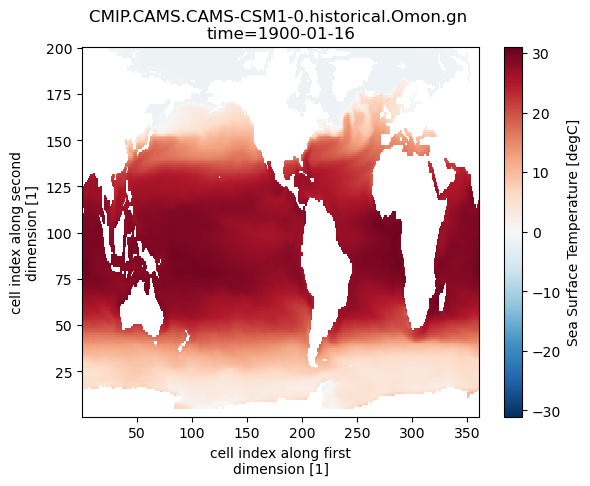

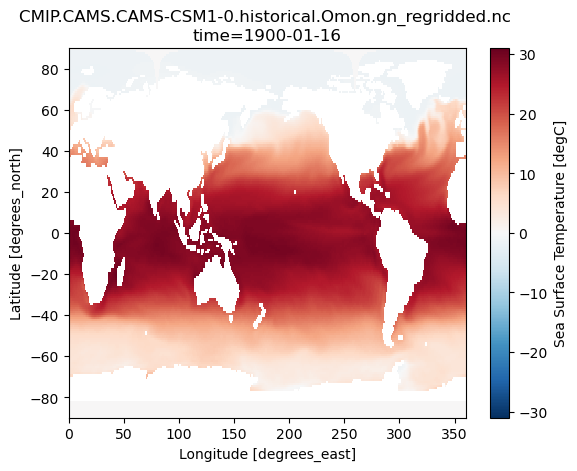





GISS-E2-1-G
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn


<xarray.Dataset> Size: 103MB
Dimensions:         (lat: 90, bnds: 2, lon: 144, time: 1980, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * lat             (lat) float64 720B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
    lat_bnds        (lat, bnds) float64 1kB dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon             (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
    lon_bnds        (lon, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 103MB dask.array<chunksize=(1, 1, 963, 90, 144), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2...
    intake_esm_attrs:version:         20180827
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NASA-GISS.GISS-E2-1-G.historical.O...

CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_regridded.nc


<xarray.Dataset> Size: 513MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                     lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
    time_bnds       (time, bnds) object 32kB ...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2...
    intake_esm_attrs:version:         20180827
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NASA-GISS.GISS-E2-1-G.historical.O...
    regrid_method:                    bilinear

No latitude / longitude coordinates


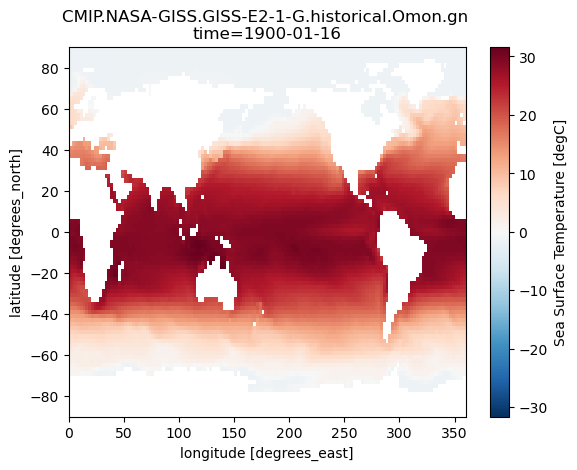

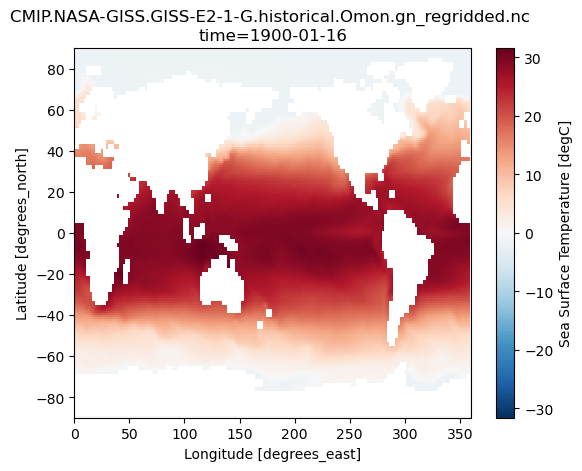





GISS-E2-1-H
CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn


<xarray.Dataset> Size: 103MB
Dimensions:         (lat: 90, bnds: 2, lon: 144, time: 1980, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * lat             (lat) float64 720B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
    lat_bnds        (lat, bnds) float64 1kB dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon             (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
    lon_bnds        (lon, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 103MB dask.array<chunksize=(1, 1, 963, 90, 144), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2...
    intake_esm_attrs:version:         20190403
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NASA-GISS.GISS-E2-1-H.historical.O...

CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn_regridded.nc


<xarray.Dataset> Size: 513MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                     lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
    time_bnds       (time, bnds) object 32kB ...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2...
    intake_esm_attrs:version:         20190403
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NASA-GISS.GISS-E2-1-H.historical.O...
    regrid_method:                    bilinear

No latitude / longitude coordinates


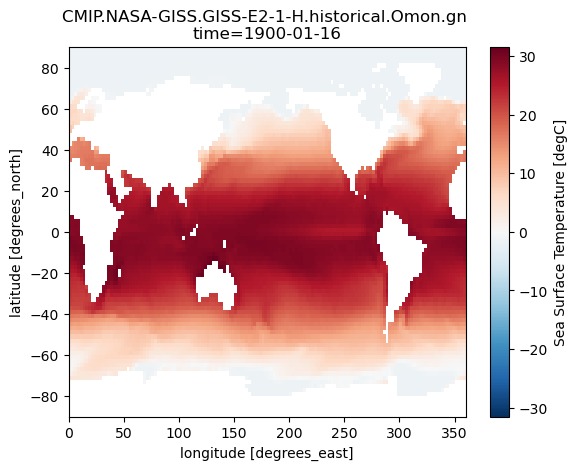

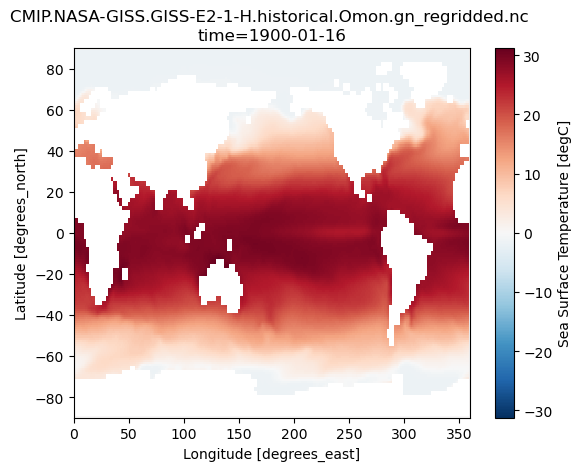





FGOALS-f3-L
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn


<xarray.Dataset> Size: 623MB
Dimensions:         (i: 360, j: 218, time: 1980, bnds: 2, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * i               (i) int32 1kB 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j               (j) int32 872B 0 1 2 3 4 5 6 ... 211 212 213 214 215 216 217
    latitude        (j, i) float64 628kB dask.array<chunksize=(218, 360), meta=np.ndarray>
    longitude       (j, i) float64 628kB dask.array<chunksize=(218, 360), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 13:00:00.000007 ... 2014-12...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, j, i) float32 622MB dask.array<chunksize=(1, 1, 158, 218, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    NCO:                              netCDF Operators version 4.8.1 (Homepag...
    activity_id:                      CMIP
    branch_method:                    Spin-up documentation
    branch_time_in_child:             674885.0
    branch_time_in_parent:            218635.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/h...
    intake_esm_attrs:version:         20191007
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CAS.FGOALS-f3-L.historical.Omon.gn

CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_regridded.nc


<xarray.Dataset> Size: 513MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                     lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 16kB 1850-01-16T13:00:00.000007 ......
    time_bnds       (time, bnds) object 32kB ...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    NCO:                              netCDF Operators version 4.8.1 (Homepag...
    activity_id:                      CMIP
    branch_method:                    Spin-up documentation
    branch_time_in_child:             674885.0
    branch_time_in_parent:            218635.0
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/h...
    intake_esm_attrs:version:         20191007
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CAS.FGOALS-f3-L.historical.Omon.gn
    regrid_method:                    bilinear

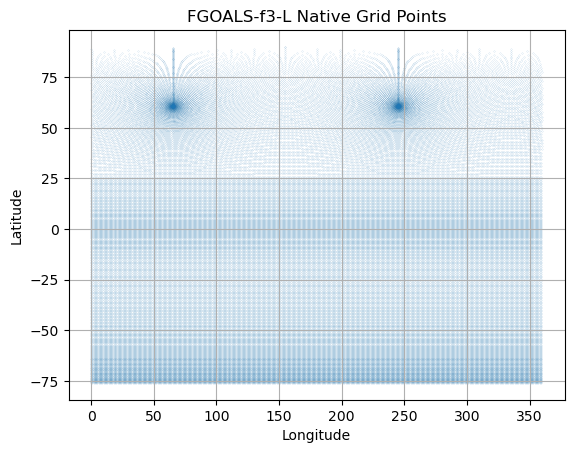

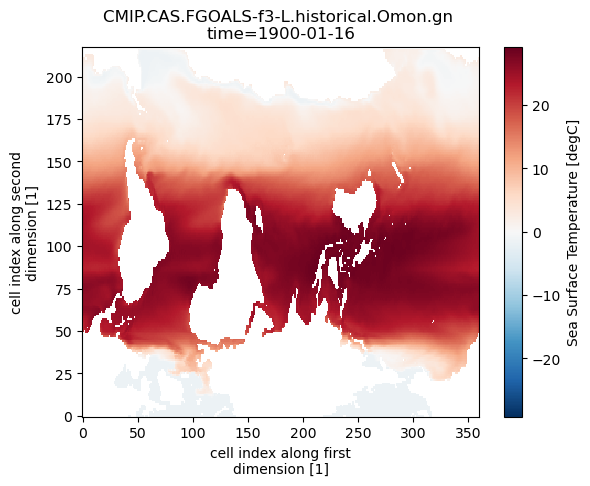

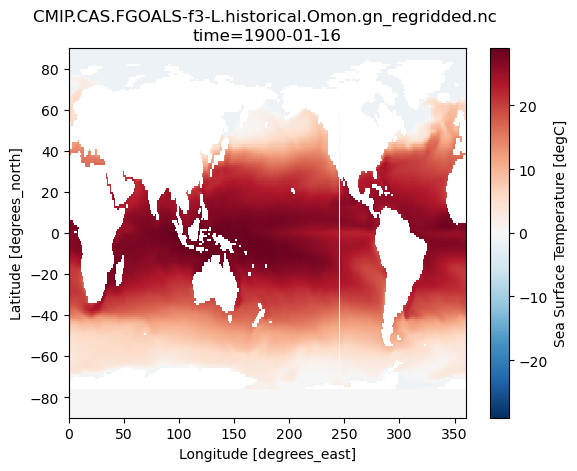





MIROC6
CMIP.MIROC.MIROC6.historical.Omon.gn


<xarray.Dataset> Size: 734MB
Dimensions:             (y: 256, x: 360, time: 1980, bnds: 2, member_id: 1,
                         dcpp_init_year: 1, vertices: 4)
Coordinates:
    latitude            (y, x) float32 369kB dask.array<chunksize=(256, 360), meta=np.ndarray>
    longitude           (y, x) float32 369kB dask.array<chunksize=(256, 360), meta=np.ndarray>
  * time                (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16...
    time_bnds           (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x                   (x) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    x_bnds              (x, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * y                   (y) float64 2kB -88.0 -85.75 -85.25 ... 150.5 152.4
    y_bnds              (y, bnds) float64 4kB dask.array<chunksize=(256, 2), meta=np.ndarray>
  * member_id           (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (member_id, dcpp_init_year, time, y, x) float32 730MB dask.array<chunksize=(1, 1, 312, 256, 360), meta=np.ndarray>
    vertices_latitude   (y, x, vertices) float32 1MB dask.array<chunksize=(256, 360, 4), meta=np.ndarray>
    vertices_longitude  (y, x, vertices) float32 1MB dask.array<chunksize=(256, 360, 4), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/hist...
    intake_esm_attrs:version:         20181212
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MIROC.MIROC6.historical.Omon.gn

CMIP.MIROC.MIROC6.historical.Omon.gn_regridded.nc


<xarray.Dataset> Size: 515MB
Dimensions:             (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                         lon: 360, vertices: 4, bnds: 2)
Coordinates:
  * time                (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 20...
    time_bnds           (time, bnds) datetime64[ns] 32kB ...
  * member_id           (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
  * lat                 (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                 (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: vertices, bnds
Data variables:
    tos                 (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...
    vertices_latitude   (vertices, lat, lon) float32 1MB ...
    vertices_longitude  (vertices, lat, lon) float32 1MB ...
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/hist...
    intake_esm_attrs:version:         20181212
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MIROC.MIROC6.historical.Omon.gn
    regrid_method:                    bilinear

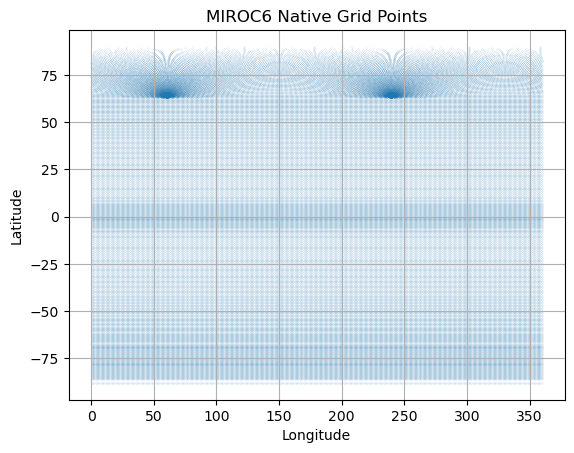

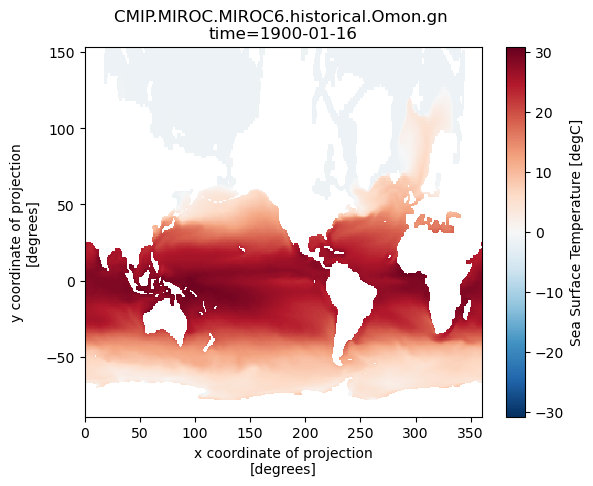

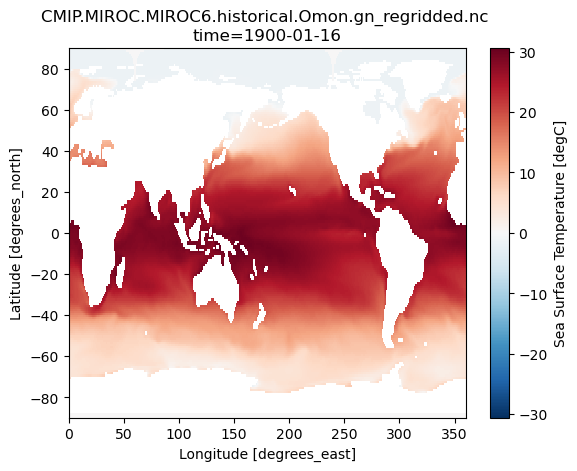

In [23]:
time_sel = "1900-01-16 12:00:00"

# Retrieve the default figure size
default_figsize = plt.rcParams["figure.figsize"]
scale_factor = 1
new_figsize = (default_figsize[0] * scale_factor, default_figsize[1] * scale_factor)


for key_regrid in list(ds_regrid_dict.keys()):

    
    
    # check if dataset contains a sea surface temperature variable
    if 'tos' in  (list(ds_regrid_dict[key_regrid].data_vars)):
        key_orig = key_regrid.replace("gn_regridded.nc", "gn").replace("gr_regridded.nc", "gr")

        print(key_orig.split(".")[2])
        
        print(key_orig)
        display(dset_dict[key_orig])

        print(key_regrid)
        display(ds_regrid_dict[key_regrid])

        if 'latitude' in dset_dict[key_orig]:
            lon = dset_dict[key_orig]['longitude'].values
            lat = dset_dict[key_orig]['latitude'].values
            plt.figure(figsize=new_figsize)
            plt.scatter(lon, lat, s=0.004)  # 's' controls the size of the points
            plt.title(f'{key_orig.split(".")[2]} Native Grid Points')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.grid(True)
            plt.show()
        else:
            print("No latitude / longitude coordinates")

        if 'latitude' in ds_regrid_dict[key_regrid]:
            lon = ds_regrid_dict[key_regrid]['longitude'].values
            lat = ds_regrid_dict[key_regrid]['latitude'].values
            plt.figure(figsize=new_figsize)
            plt.scatter(lon, lat, s=0.004)  # 's' controls the size of the points
            plt.title('Grid Points of regridded dataset')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.grid(True)
            plt.show()
        # else:
        #     print("No latitude / longitude coordinates")


        plt.figure(figsize=new_figsize)
        dset_dict[key_orig]['tos'].sel(time=time_sel).plot()
        plt.title(f"{key_orig} \ntime={time_sel.split(" ")[0]}")
        plt.show()
        
        plt.figure(figsize=new_figsize) 
        ds_regrid_dict[key_regrid]['tos'].sel(time=time_sel).plot()
        # ds_regrid_dict[key_regrid]['tos'].sel(time=time_sel).plot(x='lon', y='lat')
        plt.title(f"{key_regrid} \ntime={time_sel.split(" ")[0]}")
        plt.show()
    print("\n\n=================================================================================\n\n")

## Weight the spatial mean by the area of each grid cell
[https://earth-env-data-science.github.io/lectures/models/cmip.html](https://earth-env-data-science.github.io/lectures/models/cmip.html)

### Match cell area grid metric

Sometimes, for whatever reason, the exact metric data for a certain field might not be available. But in the case of static data, like cell area, we can assume that as long as the model (source_id) and the grid configuration (grid_label) are the same, we can use the cell area for all members.

Within the CMIP6 archive, grid metrics are stored as seperate variables like areacello (horizontal grid area), and it can be rather cumbersome to match these. xmip has some functions to make this easy, which also offer some options to use metrics from e.g. another experiment in case these are not available.

Source: [XMIP Matching metrics when the exact data is not available](https://cmip6-preprocessing.readthedocs.io/en/latest/postprocessing.html)

#### Query cloud repo for Grid-Cell Area variable
Not all the experiments include an Grid-Cell Area for Ocean `areacello` variable, therefore, we will need to match the area cells from other experiments from the same source

In [24]:
# query the cell area
variables = 'areacello' # area cells of the ocean
tables = 'Ofx'
experiments = ['historical','piControl', '1pctCO2']

print(f"Query collection for: \n• sources: All Tello sources, \n• experiments: {experiments}, \n• variables: 'areacello', \n• tables: 'Ofx', \n• members: {members}, \n• grids: {grids}")
cat_tello_area = col.search(source_id=all_tello_sources,
                        variable_id=variables,
                        table_id=tables,
                        experiment_id=experiments,
                        grid_label=grids,
                        member_id=members)

print(f"\nUnique values of source_id found: \n{list(cat_tello_area.df['source_id'].unique())}\n")

for name in all_tello_sources:
    df = cat_tello_area.df[cat_tello_area.df['source_id'].str.fullmatch(name)]
    # display(df)
    if len(df) == 0: 
        print(f"{name:17}", end=" areacello: ")
        print("not found")
        continue


Query collection for: 
• sources: All Tello sources, 
• experiments: ['historical', 'piControl', '1pctCO2'], 
• variables: 'areacello', 
• tables: 'Ofx', 
• members: ['r1i1p1f1'], 
• grids: ['gn', 'gr']

Unique values of source_id found: 
['GISS-E2-1-H', 'GISS-E2-1-G', 'MIROC6', 'BCC-ESM1', 'MPI-ESM1-2-HR', 'FGOALS-f3-L', 'MRI-ESM2-0', 'EC-Earth3-AerChem', 'EC-Earth3', 'EC-Earth3-Veg', 'CAS-ESM2-0']

MIROC-ES2L        areacello: not found
CAMS-CSM1-0       areacello: not found


#### Modify area catalog to keep one unique value per source
Select the first `experiment_id` for each `source_id`

In [25]:
cat_tello_area.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NASA-GISS,GISS-E2-1-H,piControl,r1i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/pi...,NaN,20180824
1,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
2,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20190311
3,CMIP,MIROC,MIROC6,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...,NaN,20190311
4,CMIP,MIROC,MIROC6,1pctCO2,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/1pctCO2/r1i...,NaN,20190311
5,CMIP,BCC,BCC-ESM1,1pctCO2,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/1pctCO2/r1i...,NaN,20190613
6,CMIP,MPI-M,MPI-ESM1-2-HR,1pctCO2,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/1pct...,NaN,20190710
7,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
8,CMIP,MPI-M,MPI-ESM1-2-HR,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/piCo...,NaN,20190710
9,CMIP,CAS,FGOALS-f3-L,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historic...,NaN,20190918


In [26]:
print(f"{cat_tello_area.df['source_id'].nunique()} sources out of {len(all_tello_sources)} were found")

cat_tello_area_unique = deepcopy(cat_tello_area)

# categorical order of experiments, in order to select them in this order if multiple choices for a source
cat_tello_area.df['experiment_id'] = pd.Categorical(cat_tello_area.df['experiment_id'], experiments)
tello_area_uniques_df = cat_tello_area.df.sort_values(['institution_id', 'source_id', 'experiment_id'], ascending=[True, True, True]).drop_duplicates(subset='source_id', keep='first', inplace=False).reset_index(drop=True)
tello_area_uniques_df['experiment_id'] = tello_area_uniques_df['experiment_id'].astype(str)

cat_tello_area_unique.esmcat._df = tello_area_uniques_df
cat_tello_area_unique.df

11 sources out of 13 were found


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,BCC,BCC-ESM1,1pctCO2,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/1pctCO2/r1i...,NaN,20190613
1,CMIP,CAS,CAS-ESM2-0,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CAS/CAS-ESM2-0/historica...,NaN,20201228
2,CMIP,CAS,FGOALS-f3-L,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historic...,NaN,20190918
3,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200918
4,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200624
5,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200919
6,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20190311
7,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
8,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20191210
9,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824


#### Load datasets containing areacello variable

In [27]:
# read all datasets into a dictionary (make sure to apply the same preprocessing as before!)
ddict_area = cat_tello_area_unique.to_dataset_dict(
    # preprocess=combined_preprocessing,
    zarr_kwargs={
    'consolidated': True, 
    'decode_times': True, 
    'use_cftime': True}
) 

list(ddict_area)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.CAS.CAS-ESM2-0.historical.Ofx.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Ofx.gn',
 'CMIP.CAS.FGOALS-f3-L.historical.Ofx.gn',
 'CMIP.BCC.BCC-ESM1.1pctCO2.Ofx.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.piControl.Ofx.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Ofx.gn',
 'CMIP.NASA-GISS.GISS-E2-1-H.piControl.Ofx.gr',
 'CMIP.NASA-GISS.GISS-E2-1-G.piControl.Ofx.gn',
 'CMIP.MIROC.MIROC6.historical.Ofx.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Ofx.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Ofx.gn']

#### Regrid cellarea datasets



In [28]:
# regridding tutorial: https://nordicesmhub.github.io/forces-2021/learning/example-notebooks/xesmf_regridding.html

# create dictionary for reggridded data
ds_regrid_dict_area = dict()

for key in tqdm(ddict_area.keys()):
# for key in tqdm(dset_dict_merged.keys()):

    print(key)

    # ignore dataset creating a "Degenerate Element Detected" error
    if key == "CMIP.EC-Earth-Consortium.EC-Earth3.historical.Ofx.gn" \
        or key == "CMIP.MPI-M.MPI-ESM1-2-HR.historical.Ofx.gn" \
        or key == "CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Ofx.gn" \
        or key == "CMIP.EC-Earth-Consortium.EC-Earth3-Veg.piControl.Ofx.gn":
        # or key == "CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Omon.gn":
        # or key == "CMIP.EC-Earth-Consortium.EC-Earth3.historical.Omon.gn" \
        # or key == "CMIP.MPI-M.MPI-ESM1-2-HR.historical.Omon.gn" \
        print("Degenerate Element Detected. Ignore dataset\n")
        continue

    
    # create new file name
    new_filename = key.replace(".gr", ".gr_regridded.nc").replace(".gn", ".gn_regridded.nc")
    savepath = 'datasets/CMIP6/CMIP6_regridded/areacello'
    os.makedirs(savepath, exist_ok=True) 
    nc_out = os.path.join(savepath, new_filename)

    # if regridded file already exist on disk, load it
    if os.path.isfile(nc_out):
        print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
        ds_regrid_dict_area[new_filename] = xr.open_dataset(nc_out)
        continue

    ds_in = ddict_area[key]
    
    # Convert the Dataset to another calendar (DatetimeGregorian)
    # ds_in = ddict_area[key].convert_calendar('standard', dim='time', use_cftime=True)
    
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
    print(regridder)
    
    # Apply regridder to data
    ds_in_regrid = regridder(ds_in, keep_attrs=True)

    print(f"nc_out: {nc_out}")
    ds_in_regrid.to_netcdf(nc_out)
    
    # create dataset with all models
    ds_regrid_dict_area[new_filename] = ds_in_regrid
    
    print('file written: {}\n'.format(nc_out))

  0%|          | 0/11 [00:00<?, ?it/s]

CMIP.CAS.CAS-ESM2-0.historical.Ofx.gn
CMIP.CAS.CAS-ESM2-0.historical.Ofx.gn_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/areacello. Loading it from disk...

CMIP.MPI-M.MPI-ESM1-2-HR.historical.Ofx.gn
Degenerate Element Detected. Ignore dataset

CMIP.CAS.FGOALS-f3-L.historical.Ofx.gn
CMIP.CAS.FGOALS-f3-L.historical.Ofx.gn_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/areacello. Loading it from disk...

CMIP.BCC.BCC-ESM1.1pctCO2.Ofx.gn
CMIP.BCC.BCC-ESM1.1pctCO2.Ofx.gn_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/areacello. Loading it from disk...

CMIP.EC-Earth-Consortium.EC-Earth3-Veg.piControl.Ofx.gn
Degenerate Element Detected. Ignore dataset

CMIP.EC-Earth-Consortium.EC-Earth3.historical.Ofx.gn
Degenerate Element Detected. Ignore dataset

CMIP.NASA-GISS.GISS-E2-1-H.piControl.Ofx.gr
CMIP.NASA-GISS.GISS-E2-1-H.piControl.Ofx.gr_regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/areacello. Loading it from disk...

CMIP.NASA-GISS.GI

#### Match metrics
The goal is to add the `areacello` coordinate to our datasets

In [29]:
sorted(list(ds_regrid_dict.keys()))

for key in sorted(ds_regrid_dict.keys()):
    ds = ds_regrid_dict[key]    
    split_key = key.split(".")
    print(f"{'.'.join(split_key[:2]):24} - Dims: {dict(ds.sizes)}")

CMIP.BCC                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'bnds': 2}
CMIP.CAMS                - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'vertices': 4, 'bnds': 2}
CMIP.CAS                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'bnds': 2}
CMIP.MIROC               - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'vertices': 4, 'bnds': 2}
CMIP.MRI                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'vertices': 4, 'bnds': 2}
CMIP.MRI                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'bnds': 2}
CMIP.NASA-GISS           - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'bnds': 2}
CMIP.NASA-GISS           - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'bnds'

In [30]:
sorted(list(dset_dict.keys()))

for key in sorted(dset_dict.keys()):
    ds = dset_dict[key]    
    split_key = key.split(".")
    print(f"{'.'.join(split_key[:2]):24} - Dims: {dict(ds.sizes)}")

CMIP.BCC                 - Dims: {'lat': 232, 'bnds': 2, 'lon': 360, 'time': 1980, 'member_id': 1, 'dcpp_init_year': 1}
CMIP.CAMS                - Dims: {'i': 360, 'j': 200, 'time': 1980, 'bnds': 2, 'member_id': 1, 'dcpp_init_year': 1, 'vertices': 4}
CMIP.CAS                 - Dims: {'i': 360, 'j': 218, 'time': 1980, 'bnds': 2, 'member_id': 1, 'dcpp_init_year': 1}
CMIP.EC-Earth-Consortium - Dims: {'i': 362, 'j': 292, 'time': 1980, 'bnds': 2, 'member_id': 1, 'dcpp_init_year': 1, 'vertices': 4}
CMIP.EC-Earth-Consortium - Dims: {'i': 362, 'j': 292, 'time': 1980, 'bnds': 2, 'member_id': 1, 'dcpp_init_year': 1, 'vertices': 4}
CMIP.MIROC               - Dims: {'y': 256, 'x': 360, 'time': 1980, 'bnds': 2, 'member_id': 1, 'dcpp_init_year': 1, 'vertices': 4}
CMIP.MPI-M               - Dims: {'i': 802, 'j': 404, 'time': 1980, 'bnds': 2, 'member_id': 1, 'dcpp_init_year': 1, 'vertices': 4}
CMIP.MRI                 - Dims: {'y': 363, 'x': 360, 'time': 1980, 'bnds': 2, 'member_id': 1, 'dcpp_init_yea

In [31]:
sorted(list(ds_regrid_dict_area.keys()))

for key in sorted(ds_regrid_dict_area.keys()):
    ds = ds_regrid_dict_area[key]    
    split_key = key.split(".")
    print(f"{'.'.join(split_key[:2]):24} - Dims: {dict(ds.sizes)}")

CMIP.BCC                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'lat': 180, 'lon': 360}
CMIP.CAS                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'lat': 180, 'lon': 360}
CMIP.CAS                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'lat': 180, 'lon': 360}
CMIP.MIROC               - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'lat': 180, 'lon': 360, 'vertices': 4}
CMIP.MRI                 - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'lat': 180, 'lon': 360, 'vertices': 4}
CMIP.NASA-GISS           - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'lat': 180, 'lon': 360}
CMIP.NASA-GISS           - Dims: {'member_id': 1, 'dcpp_init_year': 1, 'lat': 180, 'lon': 360}


In [32]:
matched_ds_regrid_dict = match_metrics(ds_regrid_dict, ds_regrid_dict_area, 'areacello', print_statistics=True, dim_length_conflict='align')

Processed 8 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 5}
No match found:{'areacello': 3}


/home1/fm_094/.conda/envs/enso/lib/python3.12/site-packages/xmip/postprocessing.py:673: UserWarning: No matching metrics found for areacello
  warnings.warn(f"No matching metrics found for {mv}")


#### Save regridded dataset with added regridded `areacello` coordinate

In [33]:
dset_dict_w_area = dict()

# print("Do not add datasets that don't contain 'areacello' coordinate to new dict")
for key, dataset in matched_ds_regrid_dict.items():
    if 'areacello' not in dataset:
        print(f"- {key} doesn't contain areacello coordinate. Don't keep it")
        continue

    
    # create new file name
    renamed_key = key.replace("regridded", "cellarea.regridded")
    savepath = 'datasets/CMIP6/CMIP6_regridded/w_cellarea'
    os.makedirs(savepath, exist_ok=True) 
    nc_out = os.path.join(savepath, renamed_key)

    # if file already exist on disk, load it
    if os.path.isfile(nc_out):
        print(f"+ {renamed_key} already exist in {savepath}. Loading it from disk...")
        dset_dict_w_area[renamed_key] = xr.open_dataset(nc_out)
        continue

    # print(f"nc_out: {nc_out}")
    dataset.to_netcdf(nc_out)
    print('file written: {}\n'.format(nc_out))
    
    dset_dict_w_area[renamed_key] = dataset


print("\nDatasets included in new dict (datasets where areacello matched):")
list(dset_dict_w_area.keys())

+ CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/w_cellarea. Loading it from disk...
- CMIP.MRI.MRI-ESM2-0.historical.Omon.gr_regridded.nc doesn't contain areacello coordinate. Don't keep it
+ CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/w_cellarea. Loading it from disk...
- CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn_regridded.nc doesn't contain areacello coordinate. Don't keep it
+ CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/w_cellarea. Loading it from disk...
- CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn_regridded.nc doesn't contain areacello coordinate. Don't keep it
+ CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc already exist in datasets/CMIP6/CMIP6_regridded/w_cellarea. Loading it from disk...
+ CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc already exist in d

['CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc']

### Compare original to regridded and plot

In [34]:
import numpy as np

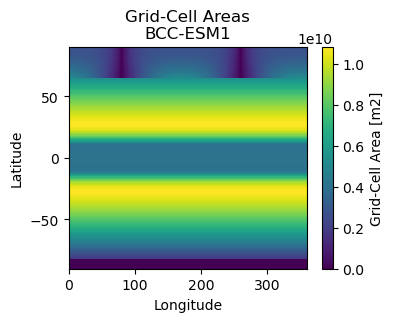

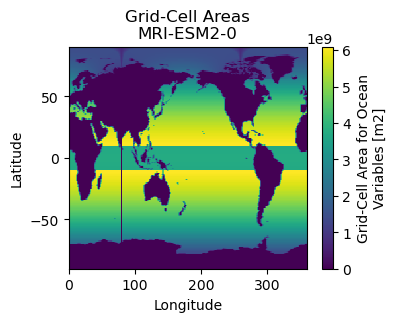

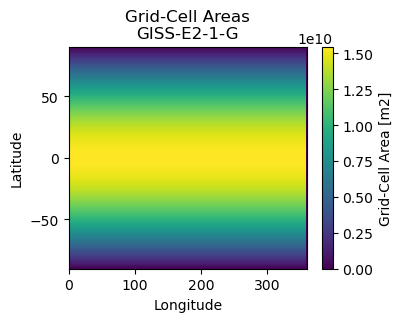

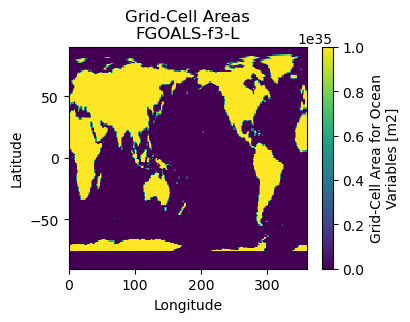

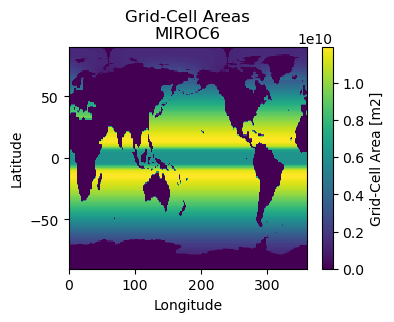

In [35]:
time_sel = "1900-01-16 12:00:00"

# Retrieve the default figure size
default_figsize = plt.rcParams["figure.figsize"]
scale_factor = 0.6
new_figsize = (default_figsize[0] * scale_factor, default_figsize[1] * scale_factor)

for key, ds in list(dset_dict_w_area.items()):
    

    member_id = ds.member_id.values[0]  # Adjust if you have a specific member_id in mind
    plt.figure(figsize=new_figsize) 
    
    ds.areacello.sel(member_id=member_id).plot()    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Grid-Cell Areas\n{key.split(".")[2]}')
    plt.show()
    # print("areacello_data: ", ds.areacello.sel(member_id=member_id))
    # print("\n\n=================================================================================\n\n")

# Ground truth (HadISST)



#### Download data from Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST)

In [36]:
HadISST_FOLDER = 'datasets/HadISST'

In [37]:
HadISST_FOLDER

'datasets/HadISST'

In [38]:
# Load or download and load data from Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST)
hadisst_filename = "HadISST_sst.nc"
hadisst_filepath = os.path.join(HadISST_FOLDER + '/raw', hadisst_filename)

if not os.path.isfile(hadisst_filepath):
    # download Sea Surface Temperature data set (HadISST)
    print(f"Downloading HadISST_sst.nc.gz from Met Office... ")
    !wget https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz -P ./datasets/HadISST/raw
    
    # decompress file and delete the .gz file after decompression
    print(f"Decompress HadISST_sst.nc.gz downloaded file... ")
    !gunzip ./datasets/HadISST/raw/HadISST_sst.nc.gz
else:
    print(f"{hadisst_filename} already exist in {HadISST_FOLDER}/raw")

print(f"Loading {hadisst_filename} from disk... ")
hadisst_ds = xr.open_dataset(hadisst_filepath)
hadisst_ds

HadISST_sst.nc already exist in datasets/HadISST/raw
Loading HadISST_sst.nc from disk... 


<xarray.Dataset> Size: 480MB
Dimensions:    (time: 1850, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB ...
    sst        (time, latitude, longitude) float32 480MB ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    2/4/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

### Rename `sst` variable to `tos`

In [39]:
hadisst_ds_ren = hadisst_ds.rename({"sst":"tos"})

### EDA

In [40]:
print(f"•  Institution: {hadisst_ds_ren.attrs['institution']}")
# print(f"•  Creation date: {hadisst_ds.attrs['creation_date'].split("T")[0]}")
print(f"•  Time: From {hadisst_ds_ren['time'][0].values.astype('datetime64[D]')} to {hadisst_ds_ren['time'][-1].values.astype('datetime64[D]')}")
print(f"•  Dimensions: {dict(hadisst_ds_ren.sizes)}")
print(f"•  {hadisst_ds_ren.data_vars}")
print()

•  Institution: Met Office Hadley Centre
•  Time: From 1870-01-16 to 2024-02-15
•  Dimensions: {'time': 1850, 'nv': 2, 'latitude': 180, 'longitude': 360}
•  Data variables:
    time_bnds  (time, nv) float32 15kB ...
    tos        (time, latitude, longitude) float32 480MB ...



In [41]:
dset_dict["CMIP.MRI.MRI-ESM2-0.historical.Omon.gr"]

<xarray.Dataset> Size: 513MB
Dimensions:         (lat: 180, bnds: 2, lon: 360, time: 1980, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bnds        (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    lon_bnds        (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB dask.array<chunksize=(1, 1, 120, 180, 360), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gr

## Regrid the model resolution to 180 x 360
xESMF is a great package for regridding

In [42]:
# display(ds_ref_grid)

In [43]:
# Read in the output grid from MRI-ESM2-0
ds_out = ds_ref_grid.copy(deep=True)

In [44]:
HadISST_FOLDER

'datasets/HadISST'

In [45]:

# create new file name
new_filename = "OBS.HAD.HADISST.regridded.nc"
savepath = HadISST_FOLDER + '/HadISST_regridded/regridded'
os.makedirs(savepath, exist_ok=True) 
nc_out = os.path.join(savepath, new_filename)

# if regridded file already exist on disk, load it
if os.path.isfile(nc_out):
    print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
    hadisst_ds_regrid = xr.open_dataset(nc_out)
else:
    ds_in = hadisst_ds_ren
    
    # Convert the Dataset to another calendar (DatetimeGregorian)
    ds_in = hadisst_ds_ren.convert_calendar('standard', dim='time', use_cftime=True)
    
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
    print(regridder)
    
    # Apply regridder to data
    hadisst_ds_regrid = regridder(ds_in, keep_attrs=True)
    
    print(f"nc_out: {nc_out}")
    hadisst_ds_regrid.to_netcdf(nc_out)
    
    # save to disk
    print('file written: {}\n'.format(nc_out))

OBS.HAD.HADISST.regridded.nc already exist in datasets/HadISST/HadISST_regridded/regridded. Loading it from disk...



In [46]:
hadisst_ds_regrid

<xarray.Dataset> Size: 480MB
Dimensions:  (time: 1850, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615 ... 2024-0...
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    tos      (time, lat, lon) float32 480MB ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    2/4/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    regrid_method:              bilinear

# GODAS dataset
To test the model performance, the Global Ocean Data Assimilation System (GODAS) reanalysis was used for theperiod 1990–2022 as we take these values to be our ground truth. We leave a 5-year gap between the training/validation period and the testing period to avoid any impact of oceanic memory, similarly to ref. 37 . Anomalieswere computed for all the variables used in this study and were coarsened to a 5◦ × 5◦ resolution in order toimprove model performance by enhancing the spatial signature of major features.
??????

In [47]:
# https://www.psl.noaa.gov/data/gridded/data.godas.html

In [48]:
GODAS_FOLDER = 'datasets/GODAS'

In [49]:
godas_pottmp_per_year_folder = os.path.join(GODAS_FOLDER + '/raw/pottmp_per_year')
print(godas_pottmp_per_year_folder)

datasets/GODAS/raw/pottmp_per_year


## Download yearly files from NOAA PSL

In [50]:
# Download and GODAS Potential Temperature datasets from NOAA PSL 
# https://www.psl.noaa.gov/data/gridded/data.godas.html

for year in range(1980, 2025, 1):
    godas_filename = f"pottmp.{year}.nc"
    godas_filepath = os.path.join(godas_pottmp_per_year_folder, godas_filename)
    if not os.path.isfile(godas_filepath):
        # download Sea Surface Temperature data set (godas) from NOAA PSL
        print(f"Downloading {godas_filename} from NOAA PSL... ")
        url = f"https://www.psl.noaa.gov/thredds/fileServer/Datasets/godas/{godas_filename}"
        !wget {url} -P ./{godas_pottmp_per_year_folder}
        print()
    else:
        print(f"{godas_filename} already exist in {GODAS_FOLDER}/raw")

pottmp.1980.nc already exist in datasets/GODAS/raw
pottmp.1981.nc already exist in datasets/GODAS/raw
pottmp.1982.nc already exist in datasets/GODAS/raw
pottmp.1983.nc already exist in datasets/GODAS/raw
pottmp.1984.nc already exist in datasets/GODAS/raw
pottmp.1985.nc already exist in datasets/GODAS/raw
pottmp.1986.nc already exist in datasets/GODAS/raw
pottmp.1987.nc already exist in datasets/GODAS/raw
pottmp.1988.nc already exist in datasets/GODAS/raw
pottmp.1989.nc already exist in datasets/GODAS/raw
pottmp.1990.nc already exist in datasets/GODAS/raw
pottmp.1991.nc already exist in datasets/GODAS/raw
pottmp.1992.nc already exist in datasets/GODAS/raw
pottmp.1993.nc already exist in datasets/GODAS/raw
pottmp.1994.nc already exist in datasets/GODAS/raw
pottmp.1995.nc already exist in datasets/GODAS/raw
pottmp.1996.nc already exist in datasets/GODAS/raw
pottmp.1997.nc already exist in datasets/GODAS/raw
pottmp.1998.nc already exist in datasets/GODAS/raw
pottmp.1999.nc already exist in

## Combine yearly files and save

In [51]:
# Load and concatenate datasets
combined_godas_filename = 'godas_combined_pottmp_5m_1980_2024.nc'
godas_folder_raw = os.path.join(GODAS_FOLDER, 'raw')
godas_5m_pottm_filepath = os.path.join(godas_folder_raw, combined_godas_filename)
if not os.path.isfile(godas_5m_pottm_filepath):
    godas_datasets = []
    for year in range(1980, 2025, 1):
        godas_filename = f"pottmp.{year}.nc"
        godas_filepath = os.path.join(godas_pottmp_per_year_folder, godas_filename)
    
        print(f"Loading {godas_filename} from disk... ")
        ds = xr.open_dataset(godas_filepath)
        
        # Filter to keep only temperature at 5m
        ds_filtered = ds.sel(level=5)
        godas_datasets.append(ds_filtered)
    
    # Concatenate datasets along the time dimension
    combined_godas_ds = xr.concat(godas_datasets, dim='time')
    
    # Save the concatenated dataset to a new NetCDF file
    combined_godas_ds.to_netcdf(godas_5m_pottm_filepath)
    print(f"Combined dataset saved to {godas_5m_pottm_filepath}")
else: 
    print(f"{combined_godas_filename} already exist in {GODAS_FOLDER}/raw")

godas_combined_pottmp_5m_1980_2024.nc already exist in datasets/GODAS/raw


## Load from disk

In [52]:
combined_godas_ds = xr.open_dataset(godas_5m_pottm_filepath)
combined_godas_ds

<xarray.Dataset> Size: 321MB
Dimensions:   (lon: 360, lat: 418, time: 534)
Coordinates:
    level     float32 4B ...
  * lon       (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float32 2kB -74.5 -74.17 -73.83 -73.5 ... 63.83 64.17 64.5
  * time      (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-06-01
Data variables:
    date      (time) int32 2kB ...
    timePlot  (time) float32 2kB ...
    pottmp    (time, lat, lon) float32 321MB ...
Attributes: (12/13)
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    Conventions:      COARDS
    grib_file:        godas.M.198001-12.grb
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    ...               ...
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    title:            GODAS: Global Ocean Data Assimilation System
    References:       https://www.psl.noaa.gov/data/gridded/data.godas.html
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    history:          Created 2006/12 by Hoop\nConverted to chunked, deflated...

## Rename `pottmp` variable to `tos`

In [53]:
combined_godas_ds_ren = combined_godas_ds.rename({"pottmp":"tos"})
combined_godas_ds_ren

<xarray.Dataset> Size: 321MB
Dimensions:   (lon: 360, lat: 418, time: 534)
Coordinates:
    level     float32 4B ...
  * lon       (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float32 2kB -74.5 -74.17 -73.83 -73.5 ... 63.83 64.17 64.5
  * time      (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-06-01
Data variables:
    date      (time) int32 2kB ...
    timePlot  (time) float32 2kB ...
    tos       (time, lat, lon) float32 321MB ...
Attributes: (12/13)
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    Conventions:      COARDS
    grib_file:        godas.M.198001-12.grb
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    ...               ...
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    title:            GODAS: Global Ocean Data Assimilation System
    References:       https://www.psl.noaa.gov/data/gridded/data.godas.html
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    history:          Created 2006/12 by Hoop\nConverted to chunked, deflated...

## EDA

In [54]:
# print(f"•  Institution: {combined_godas_ds_ren.attrs['institution']}")
# print(f"•  Creation date: {hadisst_ds.attrs['creation_date'].split("T")[0]}")
print(f"•  Time: From {combined_godas_ds_ren['time'][0].values.astype('datetime64[D]')} to {combined_godas_ds_ren['time'][-1].values.astype('datetime64[D]')}")
print(f"•  Dimensions: {dict(combined_godas_ds_ren.sizes)}")
print(f"•  {combined_godas_ds_ren.data_vars}")
print()

•  Time: From 1980-01-01 to 2024-06-01
•  Dimensions: {'lon': 360, 'lat': 418, 'time': 534}
•  Data variables:
    date      (time) int32 2kB ...
    timePlot  (time) float32 2kB ...
    tos       (time, lat, lon) float32 321MB ...



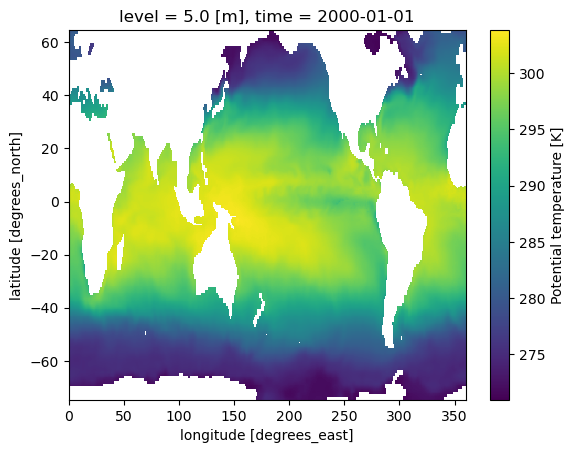

In [55]:
combined_godas_ds_ren['tos'].sel(time='2000-01-01').plot()

## Regrid the model resolution to 180 x 360
xESMF is a great package for regridding

In [56]:
# reference for regridding : CMIP.MRI.MRI-ESM2-0.historical.Omon.gr
display(ds_ref_grid)

<xarray.Dataset> Size: 513MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 180,
                     lon: 360, bnds: 2)
Coordinates:
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bnds        (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    lon_bnds        (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 513MB dask.array<chunksize=(1, 1, 120, 180, 360), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/hi...
    intake_esm_attrs:version:         20190904
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MRI.MRI-ESM2-0.historical.Omon.gr

In [57]:
# Read in the output grid from MRI-ESM2-0
ds_out = ds_ref_grid.copy(deep=True)

In [58]:
GODAS_FOLDER

'datasets/GODAS'

In [66]:

# create new file name
new_filename = "ASSIM.NOAA.GODAS.pottmp.5m.K.regridded.nc"
savepath = GODAS_FOLDER + '/GODAS_regridded/regridded'
os.makedirs(savepath, exist_ok=True) 
nc_out = os.path.join(savepath, new_filename)

# if regridded file already exist on disk, load it
if os.path.isfile(nc_out):
    print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
    godas_ds_regrid = xr.open_dataset(nc_out)
else:
    # ds_in = combined_godas_ds_ren
    
    # Convert the Dataset to another calendar (DatetimeGregorian)
    ds_in = combined_godas_ds_ren.convert_calendar('standard', dim='time', use_cftime=True)
    
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
    print(regridder)
    
    # Apply regridder to data
    godas_ds_regrid = regridder(ds_in, keep_attrs=True)
    
    print(f"nc_out: {nc_out}")
    godas_ds_regrid.to_netcdf(nc_out)
    
    # save to disk
    print('file written: {}\n'.format(nc_out))

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_418x360_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (418, 360) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False
nc_out: datasets/GODAS/GODAS_regridded/regridded/ASSIM.NOAA.GODAS.pottmp.5m.K.regridded.nc
file written: datasets/GODAS/GODAS_regridded/regridded/ASSIM.NOAA.GODAS.pottmp.5m.K.regridded.nc



In [67]:
godas_ds_regrid['tos'].sel(time='2000-01-01')

<xarray.DataArray 'tos' (time: 1, lat: 180, lon: 360)> Size: 259kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
    level    float32 4B 5.0
  * time     (time) object 8B 2000-01-01 00:00:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes: (12/15)
    dataset:                  NCEP GODAS
    var_desc:                 potential temperature
    level_desc:               Multiple Levels
    statistic:                Monthly Mean
    parent_stat:              Individual Obs
    sub_center:               Environmental Modeling Center
    ...                       ...
    level_indicator:          160
    gds_grid_type:            0
    parameter_table_version:  2
    parameter_number:         13
    actual_range:             [269.0907 305.1529]
    valid_range:              [260. 310.]

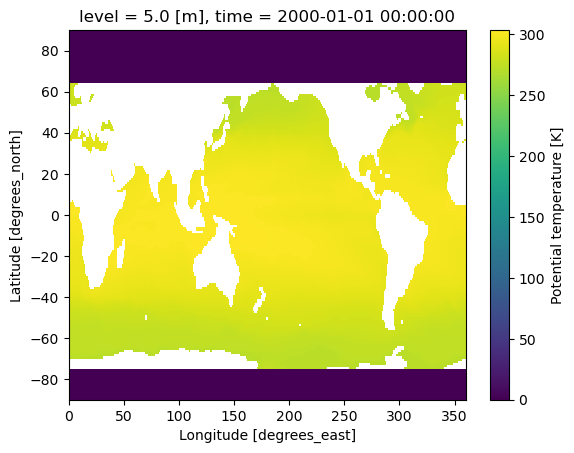

In [92]:
godas_ds_regrid['tos'].sel(time='2000-01-01').plot()
plt.show()

In [111]:
# test = godas_ds_regrid['tos'].fillna(150).sel(time='2000-01-01')
# test.plot()

In [112]:
# test2 = godas_ds_regrid.where(godas_ds_regrid != 0, 150)
# test2_tos = test2['tos'].sel(time='2000-01-01')
# test2_tos.plot()

#### Identify invalid / continents points

In [69]:
# Replace all occurrences of 0 (missing data) with NaN
godas_ds_regrid_nans = godas_ds_regrid.where(godas_ds_regrid != 0, np.nan)
godas_ds_regrid_nans

<xarray.Dataset> Size: 138MB
Dimensions:  (time: 534, lat: 180, lon: 360)
Coordinates:
    level    float32 4B 5.0
  * time     (time) object 4kB 1980-01-01 00:00:00 ... 2024-06-01 00:00:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    tos      (time, lat, lon) float32 138MB nan nan nan nan ... nan nan nan nan
Attributes: (12/14)
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    Conventions:      COARDS
    grib_file:        godas.M.198001-12.grb
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    ...               ...
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    title:            GODAS: Global Ocean Data Assimilation System
    References:       https://www.psl.noaa.gov/data/gridded/data.godas.html
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    history:          Created 2006/12 by Hoop\nConverted to chunked, deflated...
    regrid_method:    bilinear

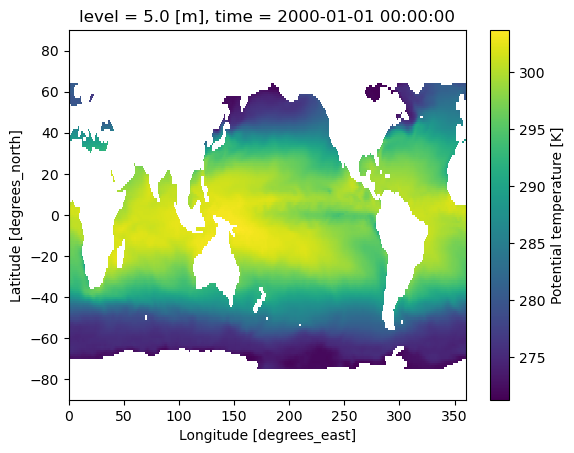

In [70]:
godas_ds_regrid_nans['tos'].sel(time='2000-01-01').plot()
plt.show()

## Convert Kelvin into Celsius
$C = K - 273.15 $

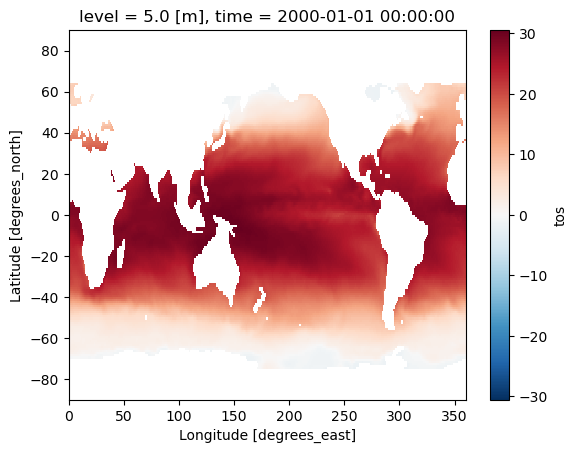

In [71]:
godas_ds_regrid_celsius = godas_ds_regrid_nans['tos'] - 273.15
godas_ds_regrid_celsius.sel(time='2000-01-01').plot()

In [81]:
# drop the level coordinate in order to be able to stack it with other datasets in future notebooks
godas_ds_regrid_celsius_drop_level = godas_ds_regrid_celsius.drop_vars('level')
godas_ds_regrid_celsius_drop_level

<xarray.Dataset> Size: 138MB
Dimensions:  (time: 534, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-06-01
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    tos      (time, lat, lon) float32 138MB ...

In [85]:
# create new file name
new_filename = "ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc"
savepath = GODAS_FOLDER + '/GODAS_regridded/regridded'
os.makedirs(savepath, exist_ok=True) 
nc_out = os.path.join(savepath, new_filename)

# if regridded file already exist on disk, load it
if os.path.isfile(nc_out):
    print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
    godas_ds_regrid_celsius_drop_level = xr.open_dataset(nc_out)
else:    
    print(f"nc_out: {nc_out}")
    godas_ds_regrid_celsius_drop_level.to_netcdf(nc_out)
    
    # save to disk
    print('file written: {}\n'.format(nc_out))

godas_ds_regrid_celsius_drop_level

ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc already exist in datasets/GODAS/GODAS_regridded/regridded. Loading it from disk...



<xarray.Dataset> Size: 138MB
Dimensions:  (time: 534, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-06-01
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    tos      (time, lat, lon) float32 138MB ...